# Getting started with PyMC3

[Tutorial](https://docs.pymc.io/notebooks/getting_started.html)

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm

%config InlineBackend.figure_format = "retina"
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
gg.theme_set(gg.theme_minimal)

## A Motivating Example: Linear Regression

$$
Y \sim \mathcal{N}(\mu, \sigma^2) \\
\mu = \alpha + \beta_1 X_1 + \beta_2 X_2 \\
\alpha \sim \mathcal{N}(0, 10) \\
\beta_1 \sim \mathcal{N}(0, 10) \\
\beta_2 \sim \mathcal{N}(0, 10) \\
\sigma \sim |\mathcal{N}(0, 1)|
$$

/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/plotnine/facets/facet_wrap.py:215: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


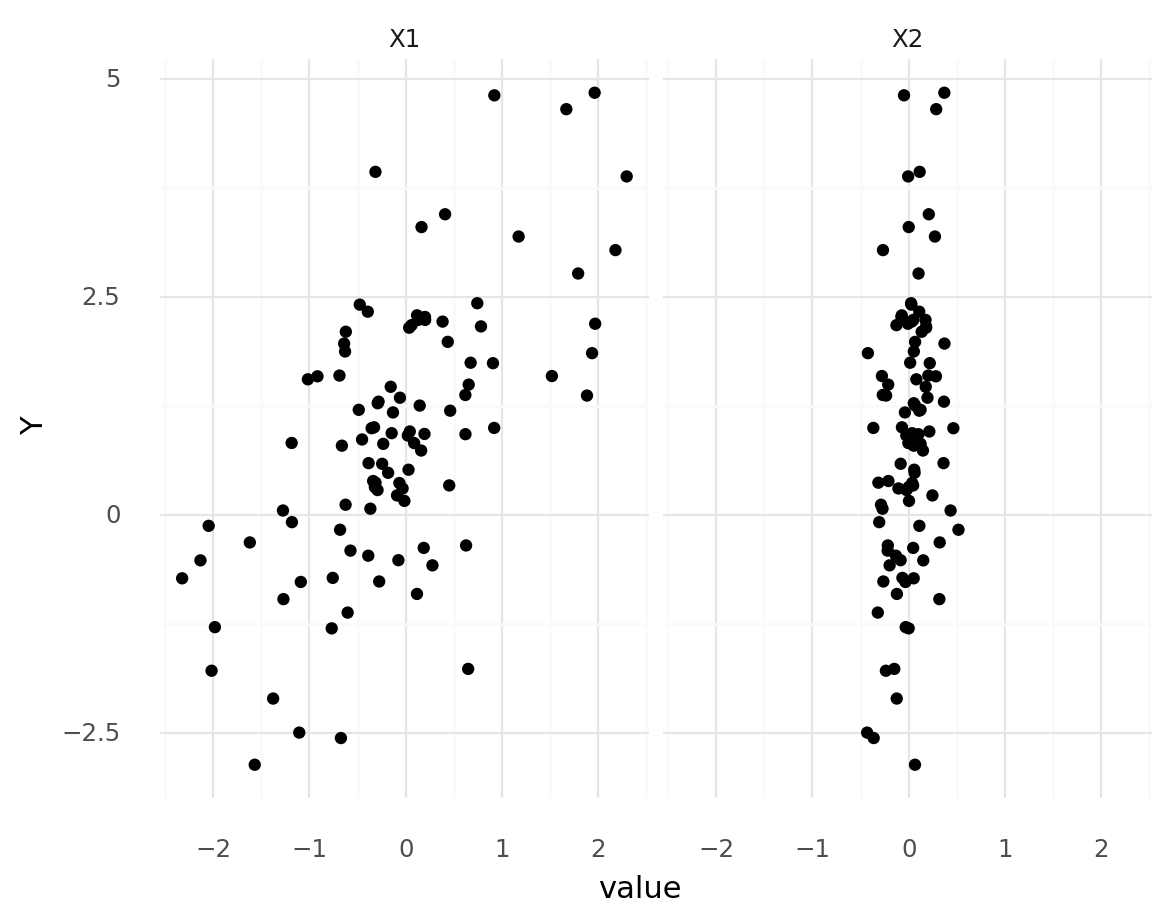

<ggplot: (354234362)>

In [2]:
alpha, sigma = 1, 1
beta = [1, 2.5]

size = 100

X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

Y = alpha + beta[0] * X1 + beta[1] * X2 + (np.random.randn(size) * sigma)

d = pd.DataFrame({"X1": X1, "X2": X2, "Y": Y}).melt(id_vars="Y")

(
    gg.ggplot(d, gg.aes("value", "Y"))
    + gg.facet_wrap("variable", nrow=1, scales="fixed")
    + gg.geom_point()
)

In [3]:
with pm.Model() as basic_model:
    alpha = pm.Normal("alpha", 0, 10)
    beta = pm.Normal("beta", 0, 10, shape=2)
    sigma = pm.HalfNormal("sigma", 1)

    mu = alpha + beta[0] * X1 + beta[1] * X2

    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

    trace = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 34 seconds.


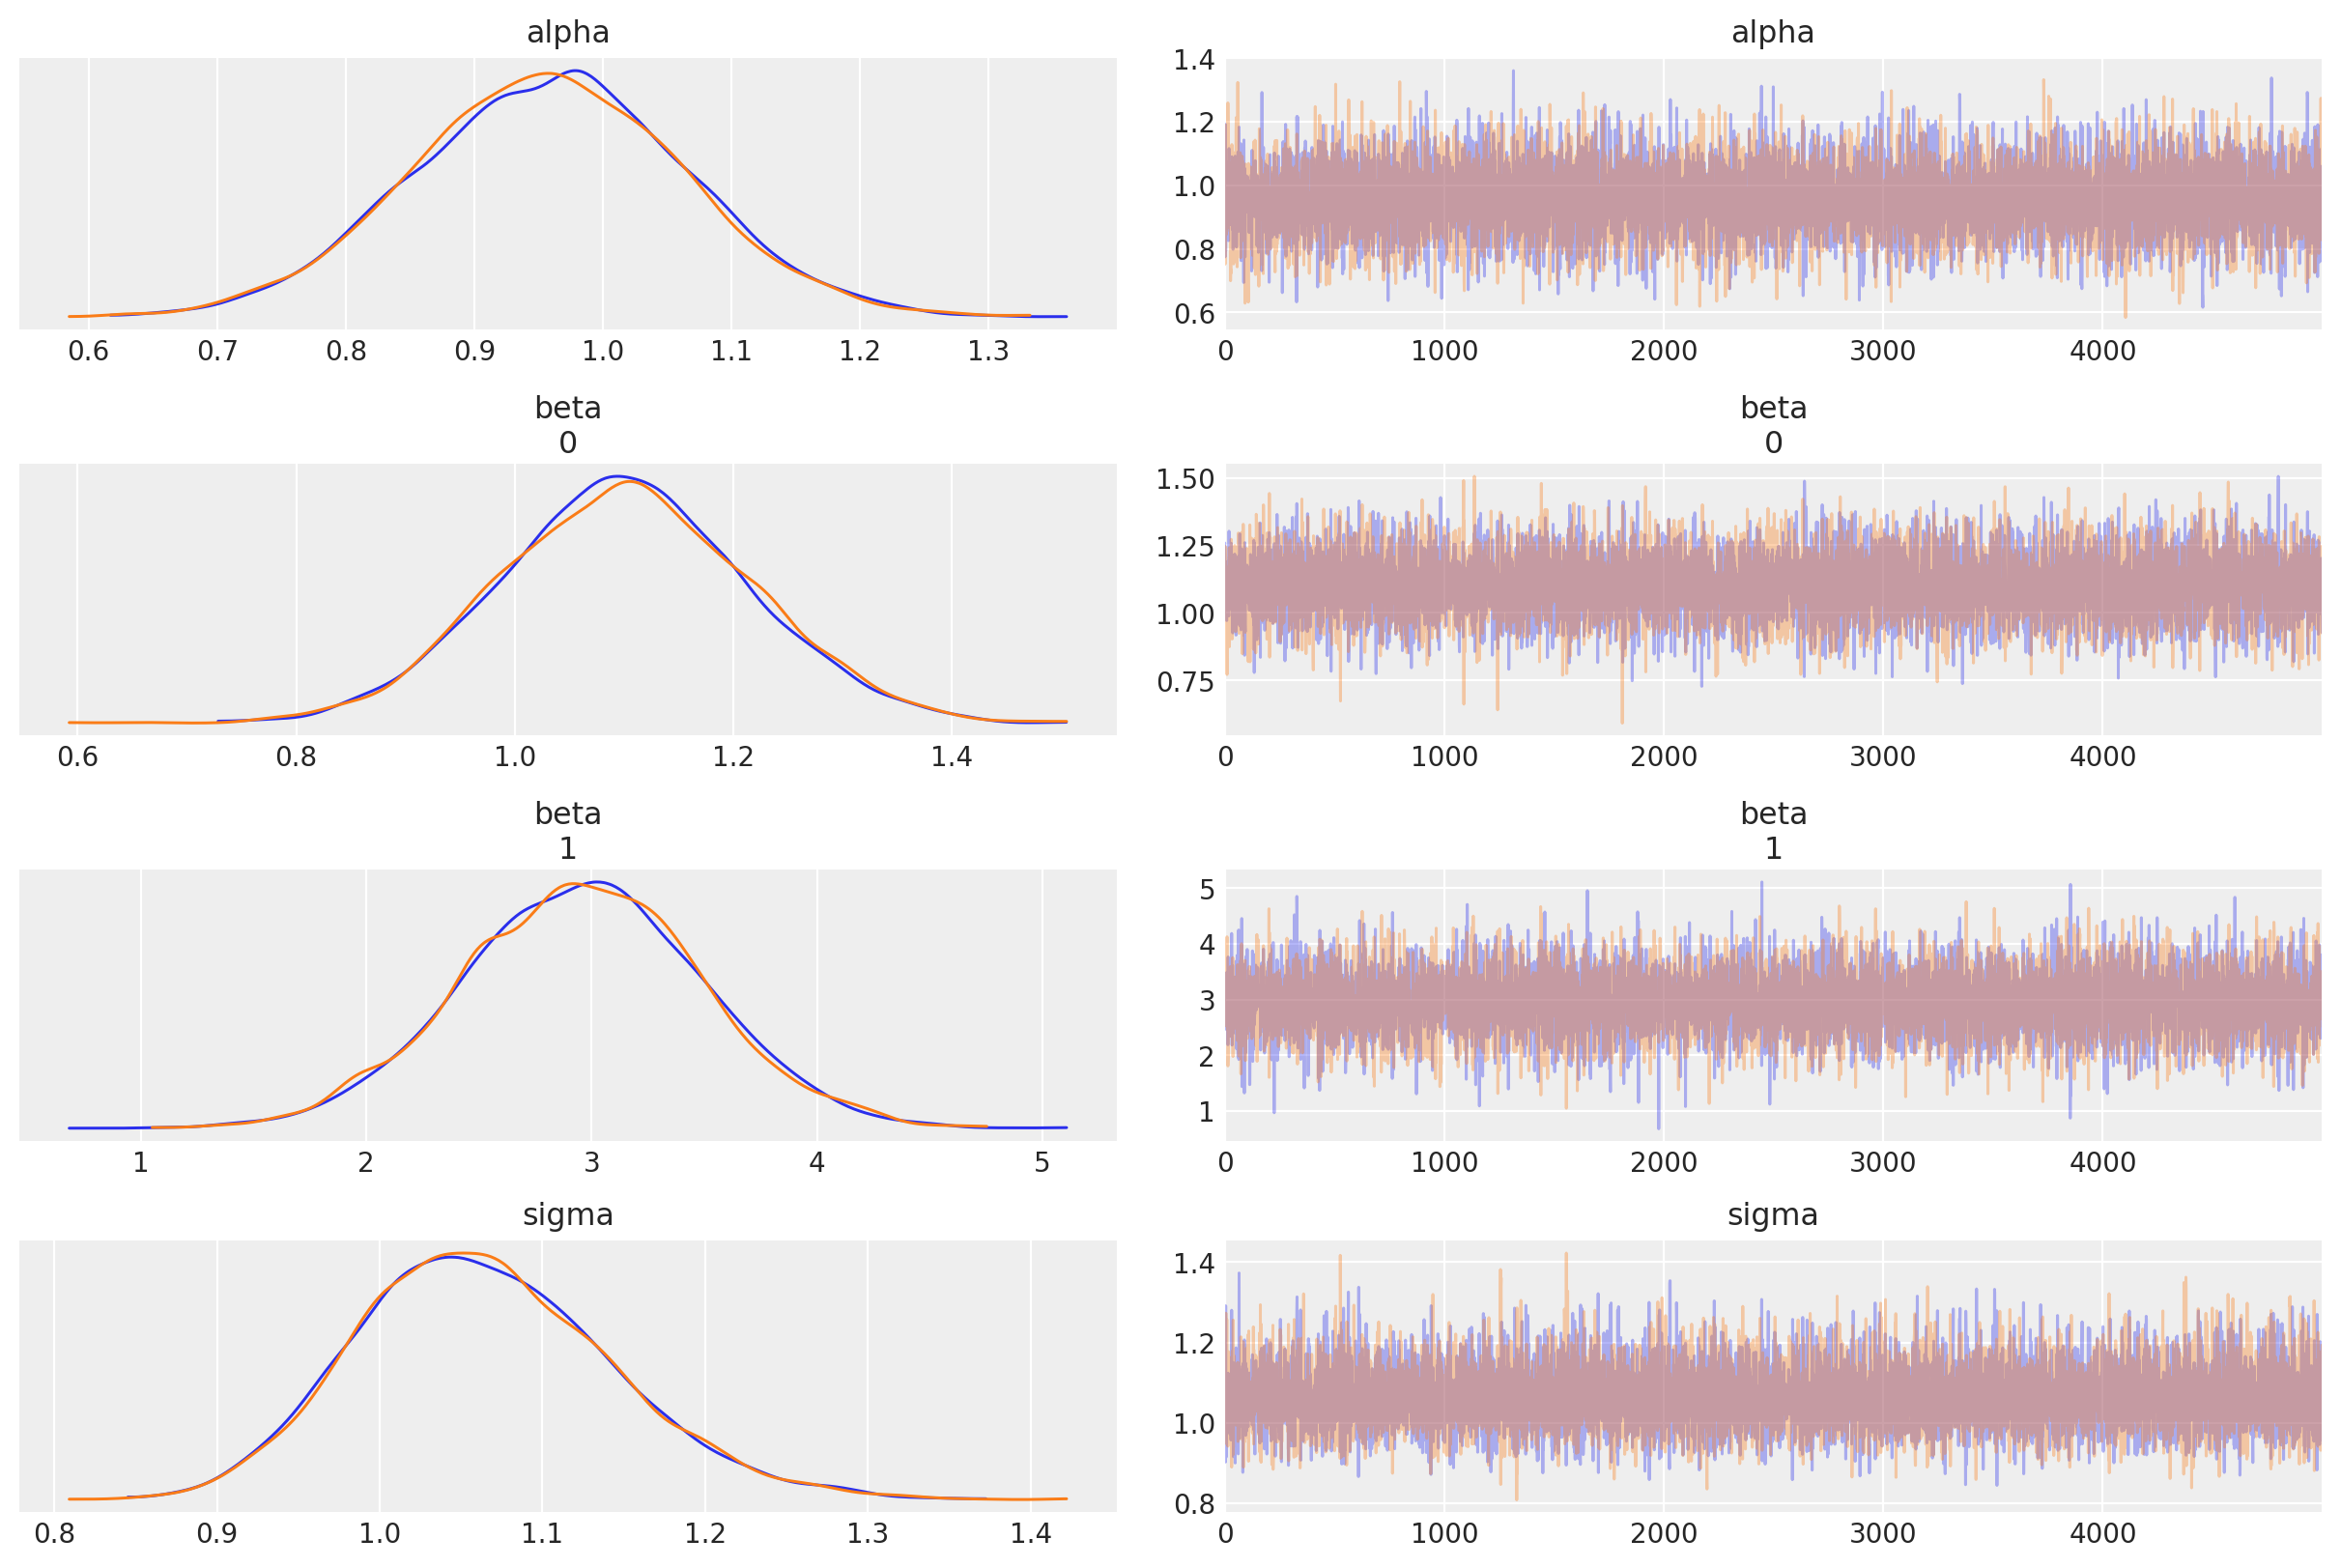

In [4]:
az.plot_trace(trace, compact=False)
plt.show()

In [5]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.958,0.107,0.759,1.162,0.001,0.001,15834.0,15524.0,15831.0,8046.0,1.0
beta[0],1.101,0.114,0.893,1.319,0.001,0.001,13106.0,12921.0,13088.0,7863.0,1.0
beta[1],2.952,0.540,1.891,3.920,0.004,0.003,15443.0,14832.0,15497.0,7830.0,1.0
sigma,1.064,0.079,0.917,1.209,0.001,0.001,12512.0,12036.0,13024.0,7047.0,1.0


## Case Study 1: Stochastic volatility

A case study on stock market volatility.
The distribution of market returns is non-normal, making smapling more difficult.

Asset prices have *time-varying volatility*, variance of day-over-day returns.
Sometimes, returns are highly volatile and other times prices are more stable.
This *stochasitc volatility model* addresses this with a latent volatility variable than changes over time.

$$
\log(r_i) \sim t(\nu, 0, \exp(-2s_i)) \\
s_i \sim \mathcal{N}(s_{i-1}, \sigma^2) \\
\nu \sim \exp(0.1) \\
\sigma \sim \exp(50)
$$

Here, $R$ is the faily return series modeled with a Student's *t*-distribution with an unknown degrees of freedom parameter $\nu$ and a scale parameter determined by a latent process $s$.
An individual $s_i$ is an individual daily log volatilities in the latent log volatility process.

Use data from S&P 500 indexsince the 2008 crisis.

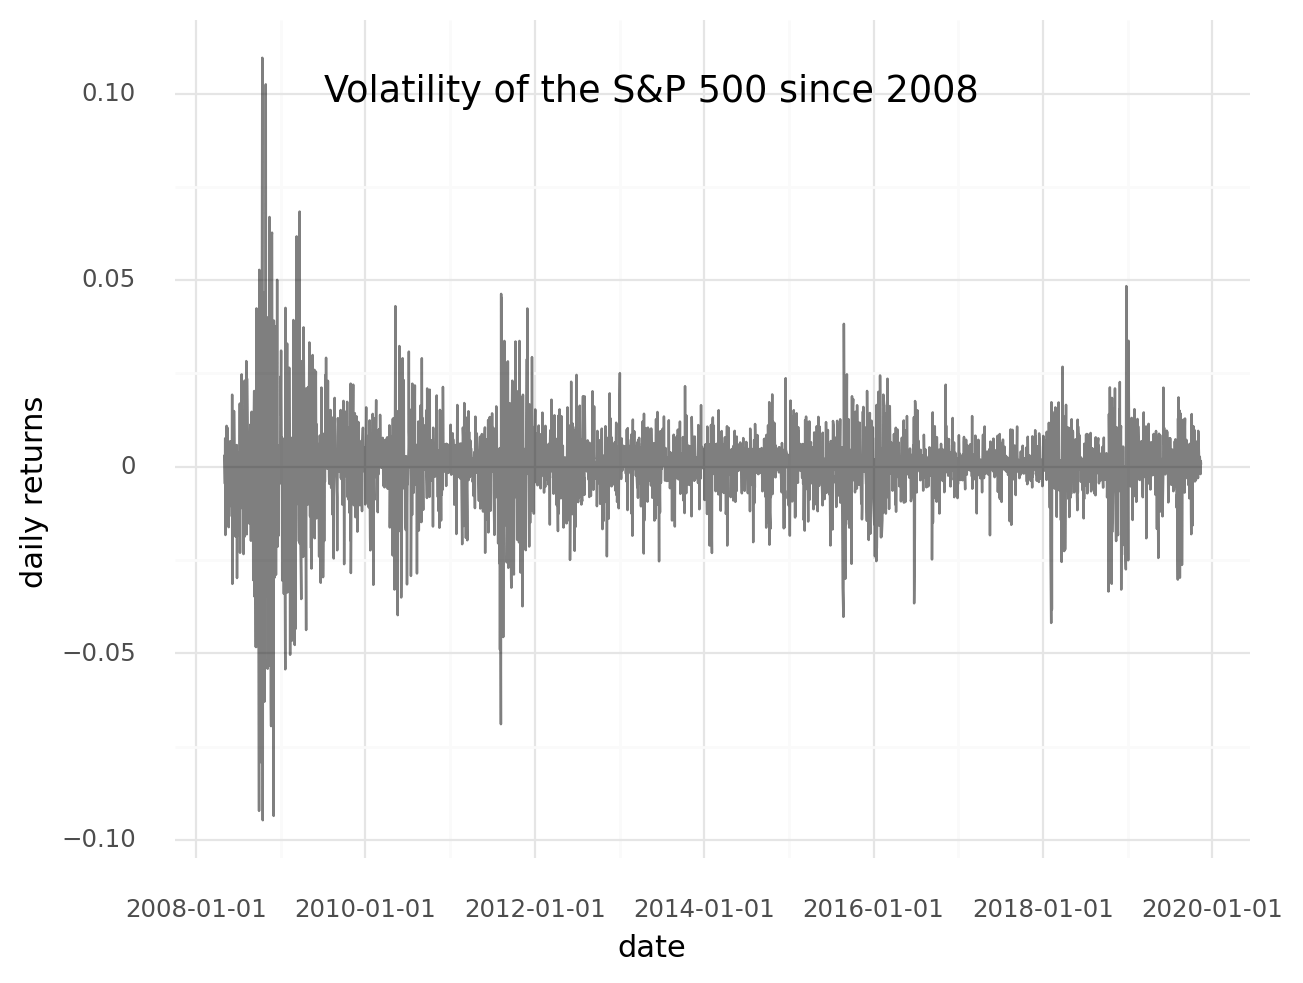

<ggplot: (351797041)>

In [6]:
returns = pd.read_csv(
    pm.get_data("SP500.csv"), parse_dates=True, index_col=0, usecols=["Date", "change"]
).reset_index(drop=False)

(
    gg.ggplot(returns, gg.aes(x="Date", y="change"))
    + gg.geom_line(alpha=0.5, size=0.5)
    + gg.labs(x="date", y="daily returns", title="Volatility of the S&P 500 since 2008")
)

Use a `GaussianRandomWalk` as the prior for the latent volatilities.
It is a vector-valued distribution where the values of the vector form a random normal walk of length $n$, specified by the `shape` parameter.

We can provide initial values for any distribution, known as *test values*, using the `testval` parameter.
This can be useful if some values are illegal and we want to ensure a legal value is selected.

In [7]:
with pm.Model() as sp500_model:
    change_returns = pm.Data(
        "returns", returns["change"], dims="date", export_index_as_coords=True
    )

    nu = pm.Exponential("nu", 1.0 / 10.0, testval=5.0)
    sigma = pm.Exponential("sigma", 2.0, testval=0.1)

    s = pm.GaussianRandomWalk("s", sigma=sigma, dims="date")

    volatility_process = pm.Deterministic(
        "volatility_process", pm.math.exp(-2 * s) ** 0.5, dims="date"
    )

    r = pm.StudentT(
        "r", nu=nu, sigma=volatility_process, observed=change_returns, dims="date"
    )

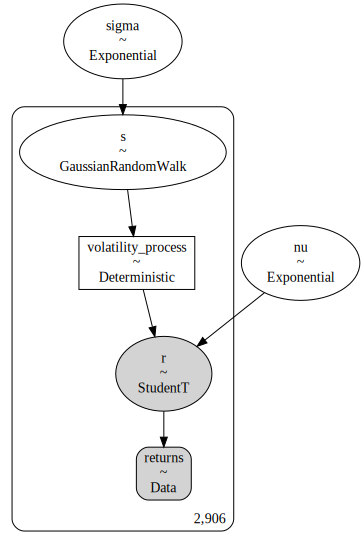

In [8]:
pm.model_to_graphviz(sp500_model)

In [9]:
sp500_model.RV_dims

{'returns': ('date',),
 's': ('date',),
 'volatility_process': ('date',),
 'r': ('date',)}

In [10]:
sp500_model.coords

{'date': RangeIndex(start=0, stop=2906, step=1)}

In [11]:
with sp500_model:
    trace = pm.sample(2000, init="adapt_diag", return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [s, sigma, nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 512 seconds.


0, dim: date, 2906 =? 2906


The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


0, dim: date, 2906 =? 2906
0, dim: date, 2906 =? 2906


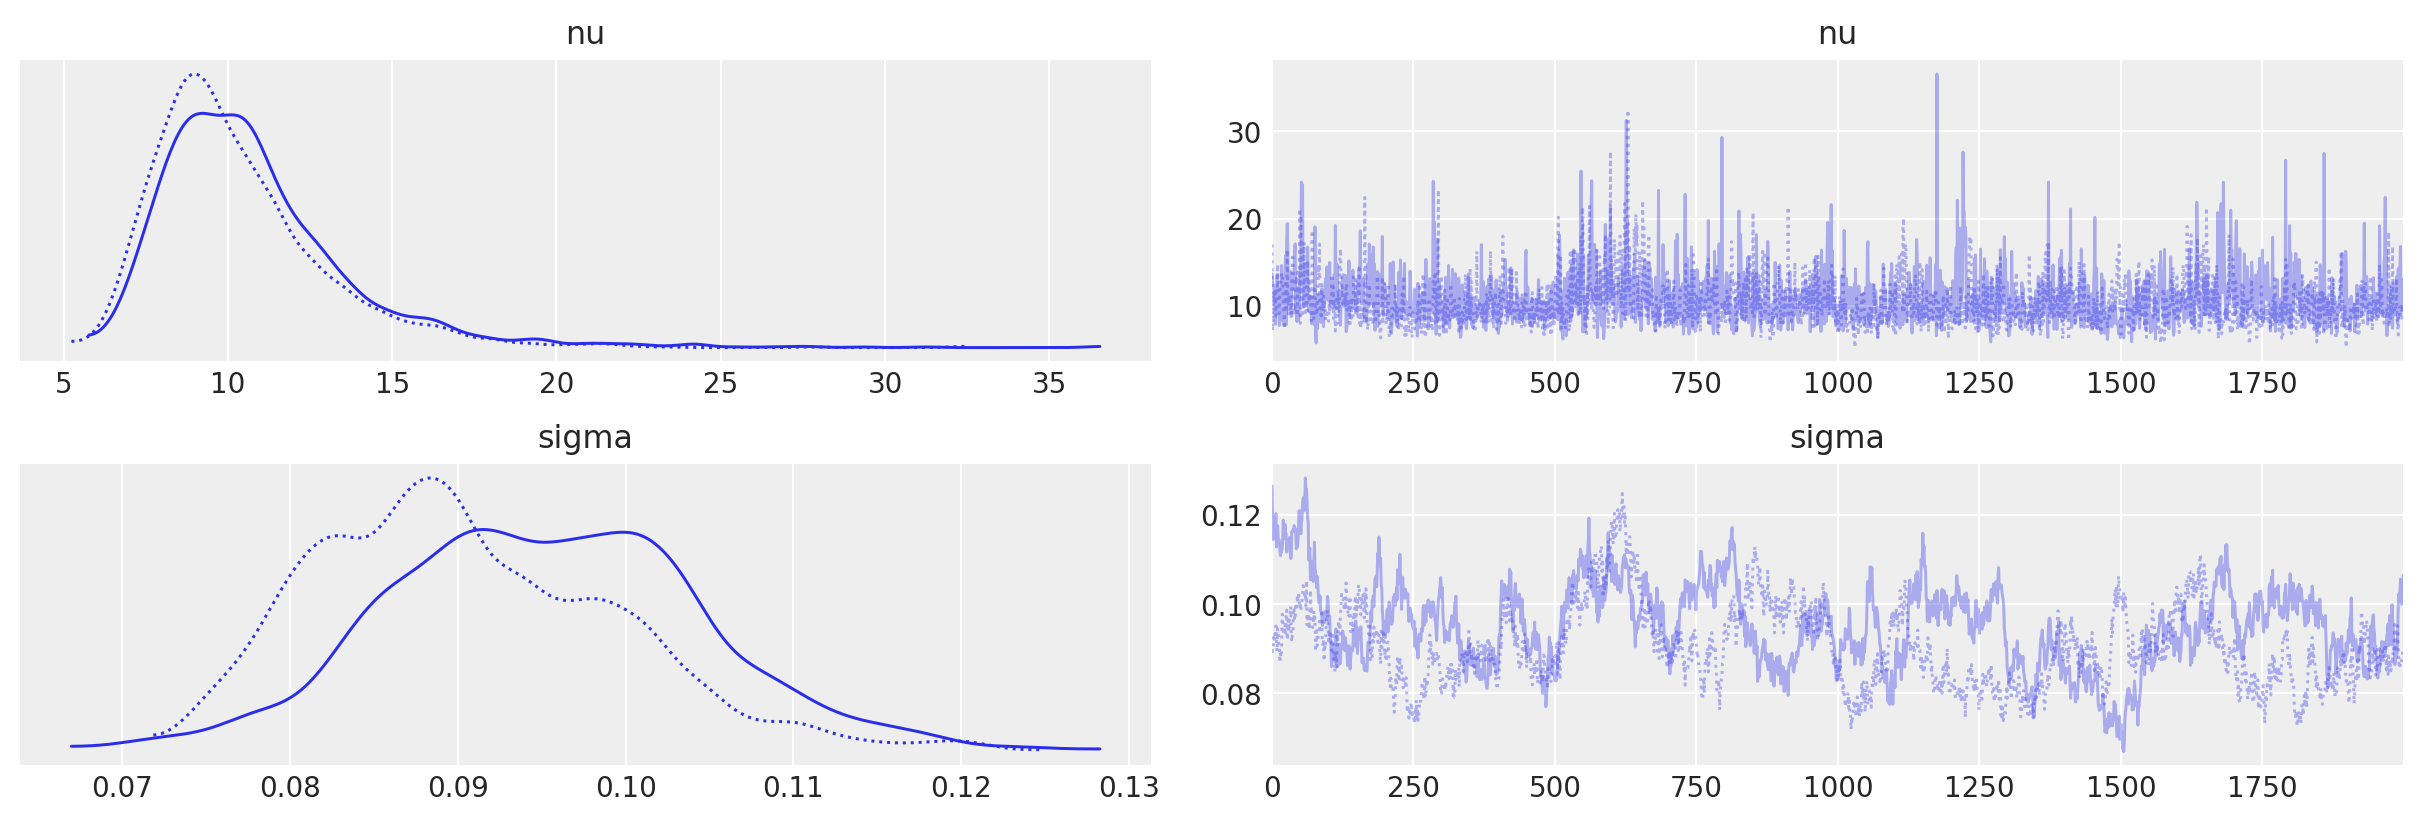

In [12]:
az.plot_trace(trace, combined=False, var_names=["nu", "sigma"])
plt.show()

/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


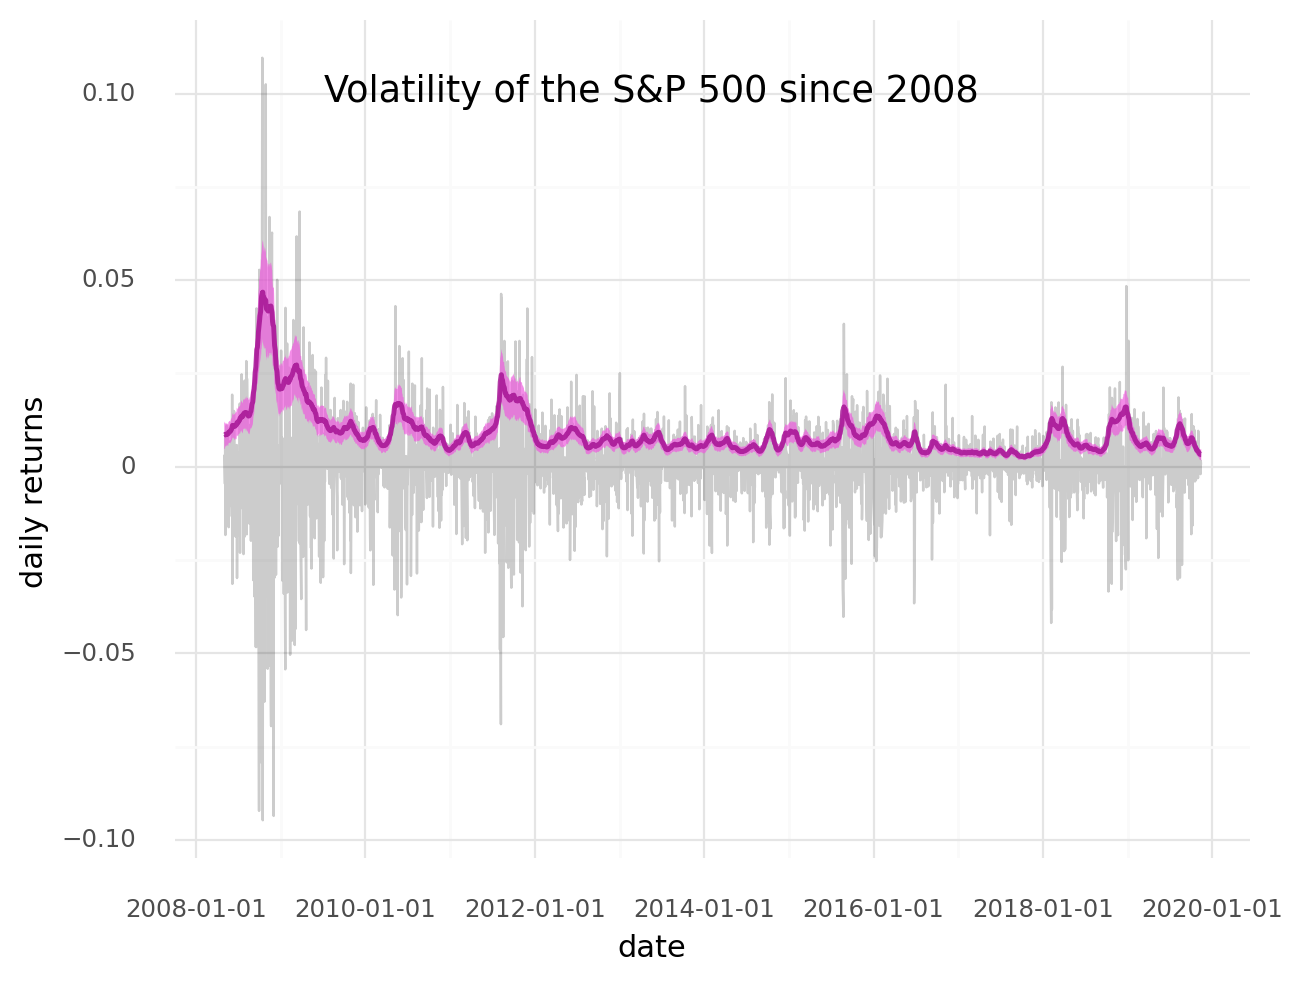

<ggplot: (351180939)>

In [45]:
volatility_post = 1 / np.exp(trace["s", ::5].T)
volatility_post_hdi = az.hdi(volatility_post.T, hdi_prob=0.89)
plot_data = returns.copy()
plot_data["volatility"] = volatility_post.mean(axis=1)
plot_data["volatility_lower"] = volatility_post_hdi[:, 0]
plot_data["volatility_high"] = volatility_post_hdi[:, 1]

(
    gg.ggplot(plot_data, gg.aes(x="Date"))
    + gg.geom_line(gg.aes(y="change"), alpha=0.2, size=0.5)
    + gg.geom_ribbon(
        gg.aes(ymin="volatility_lower", ymax="volatility_high"),
        alpha=0.7,
        fill="#EF5BDE",
    )
    + gg.geom_line(gg.aes(y="volatility"), alpha=0.8, color="#A10D90", size=1)
    + gg.labs(x="date", y="daily returns", title="Volatility of the S&P 500 since 2008")
)

## Case Study 2: Coal mining disasters

Data is a time series of recorded coal mining disasters in the UK from 1851 to 1962.
The number of disasters is affected by changes in safety regulations.
There are two years with missing data, but *these missing values with be automatically imputed by PyMC3*.

Build a model to estimate when the change occurred and see how the model handles missing data.

In [17]:
disasters_data = pd.read_csv("data/mining_disasters.txt", header=None)
disasters_data.columns = ["n_disasters"]
disasters_data[["year"]] = np.arange(1851, 1962)
disasters_data.head()

,n_disasters,year
0,4.0,1851
1,5.0,1852
2,4.0,1853
3,0.0,1854
4,1.0,1855


In [18]:
# Missing data
disasters_data[disasters_data.n_disasters.isna()]

,n_disasters,year
39,NaN,1890
83,NaN,1934


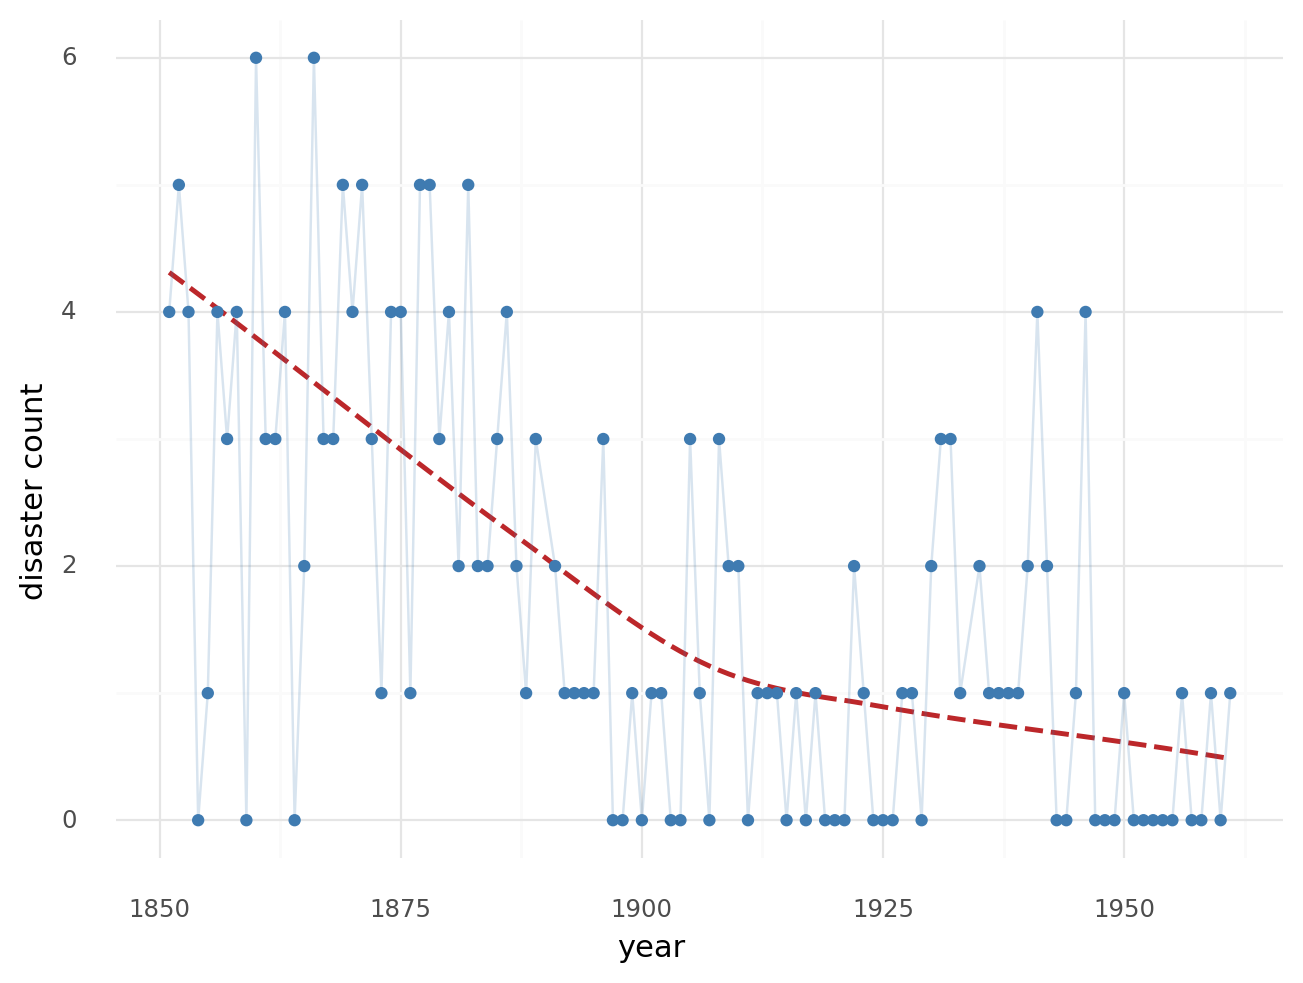

<ggplot: (362940591)>

In [19]:
(
    gg.ggplot(
        disasters_data[~disasters_data.n_disasters.isna()],
        gg.aes(x="year", y="n_disasters"),
    )
    + gg.geom_smooth(se=False, linetype="--", color="#BC272A")
    + gg.geom_line(group="a", alpha=0.2, color="#3F7BB1")
    + gg.geom_point(color="#3F7BB1")
    + gg.labs(x="year", y="disaster count")
)

The occurrence of disasters follows a Poisson process with a large rate parameter early on but a smaller parameter later.
We want to locate the change point in the series.

$$
\begin{align}
D_t & \sim \text{Pois}(r_t), r_t = 
\begin{cases}
 e, & \text{if } t \leq s \\
 l, & \text{if } t \gt s
\end{cases} \\
s & \sim \text{Unif}(t_l, t_h) \\
e & \sim \exp(1) \\
l & \sim \exp(1)
\end{align}
$$

In this model, $s$ is the switchpoint between "early" and "late" rate parameters ($e$ and $l$).

masked_array(data=[ 4.,  5.,  4.,  0.,  1.,  4.,  3.,  4.,  0.,  6.,  3.,
                    3.,  4.,  0.,  2.,  6.,  3.,  3.,  5.,  4.,  5.,  3.,
                    1.,  4.,  4.,  1.,  5.,  5.,  3.,  4.,  2.,  5.,  2.,
                    2.,  3.,  4.,  2.,  1.,  3., nan,  2.,  1.,  1.,  1.,
                    1.,  3.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  3.,
                    1.,  0.,  3.,  2.,  2.,  0.,  1.,  1.,  1.,  0.,  1.,
                    0.,  1.,  0.,  0.,  0.,  2.,  1.,  0.,  0.,  0.,  1.,
                    1.,  0.,  2.,  3.,  3.,  1., nan,  2.,  1.,  1.,  1.,
                    1.,  2.,  4.,  2.,  0.,  0.,  1.,  4.,  0.,  0.,  0.,
                    1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
                    1.],
             mask=False,
       fill_value=1e+20)

In [29]:
with pm.Model() as disaster_model:
    # Switchpiont
    switchpoint = pm.DiscreteUniform(
        "switchpoint",
        lower=disasters_data.year.min(),
        upper=disasters_data.year.max(),
        testval=1900,
    )

    # Priors for early and late rates.
    early_rate = pm.Exponential("early_rate", 1.0)
    late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates using the switchpoint.
    rate = pm.math.switch(switchpoint >= disasters_data.year, early_rate, late_rate)

    # Observed data.
    disasters = pm.Poisson("disasters", rate, observed=disasters_data.n_disasters)

/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/pymc3/model.py:1668: ImputationWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.


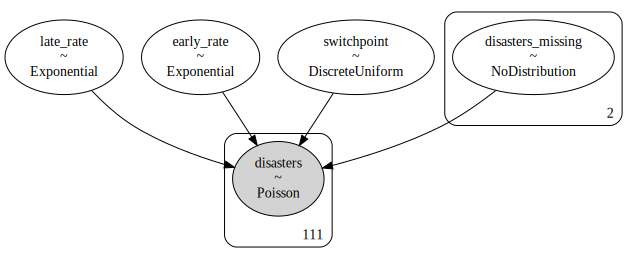

In [30]:
pm.model_to_graphviz(disaster_model)

NUTS cannot be used to sample because the data is discrete.
Instead, need to use a Metropolis step method that implements adaptive Metropolis-Hastings.
PyMC3 handles this automatically.

In [28]:
with disaster_model:
    trace = pm.sample(10000, random_seed=RANDOM_SEED)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 37 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [31]:
disaster_az = az.from_pymc3(trace=trace, model=disaster_model)

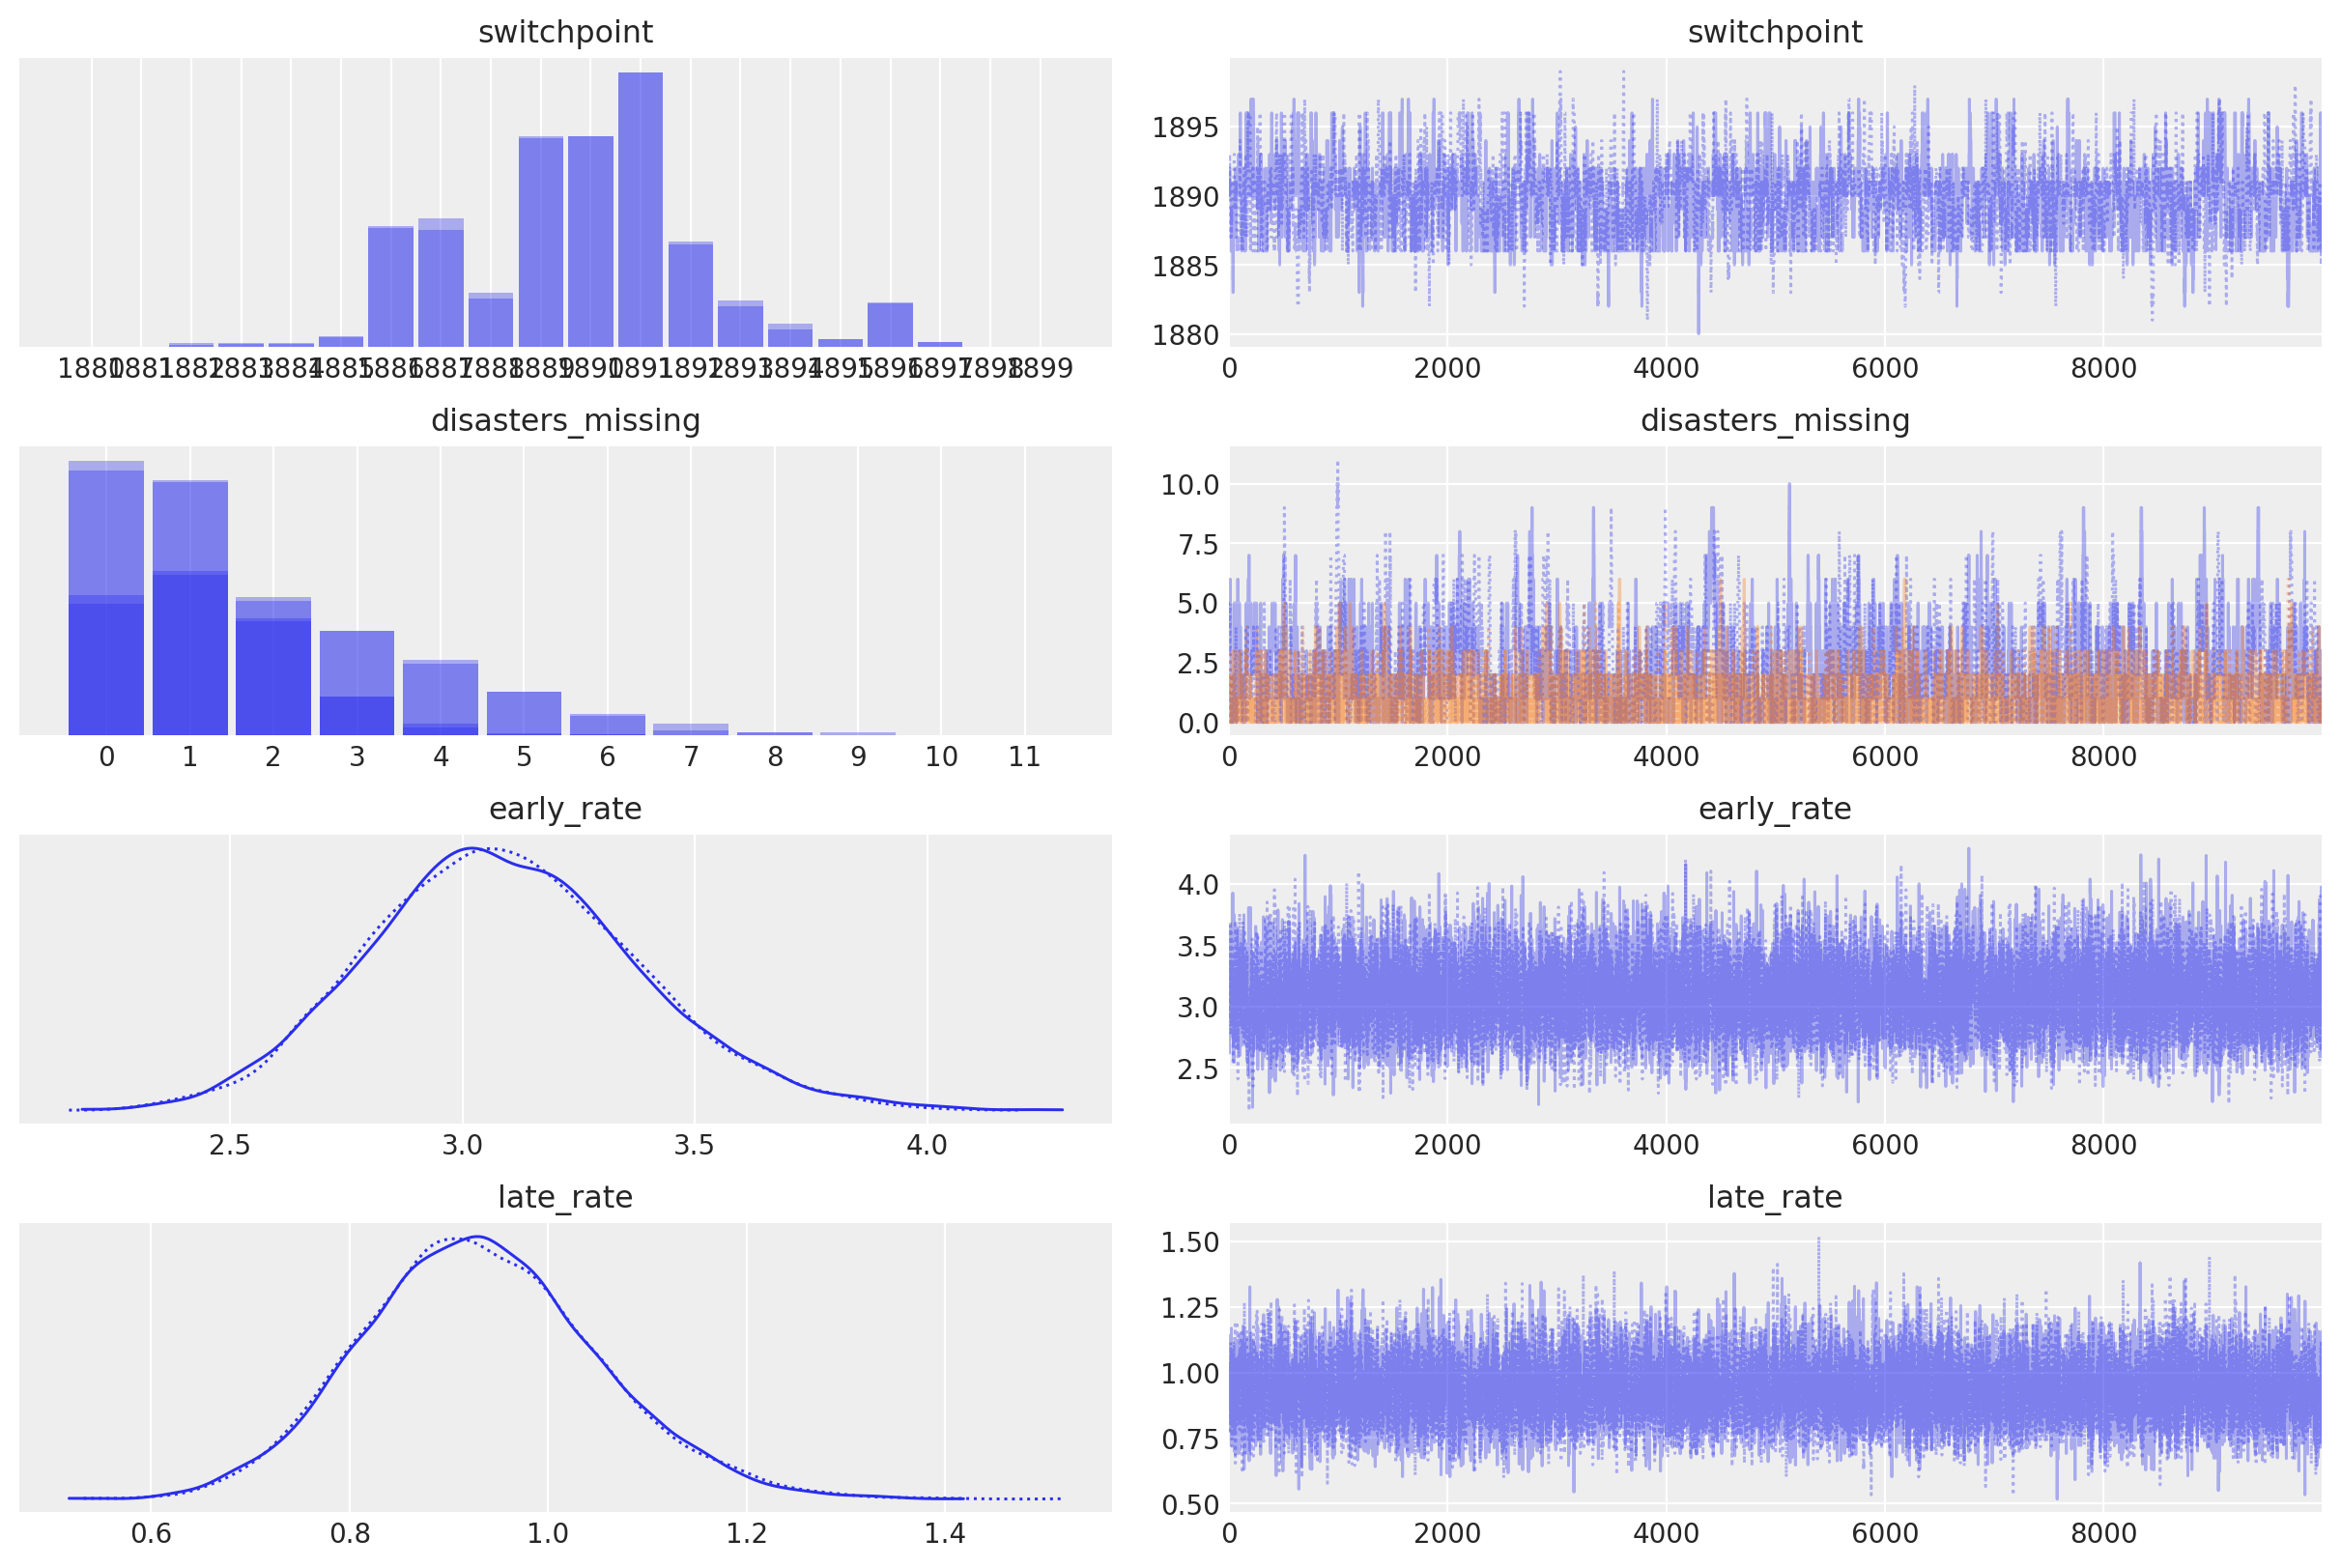

In [33]:
az.plot_trace(disaster_az)
plt.show()

Posterior distribution for the switchpoint.

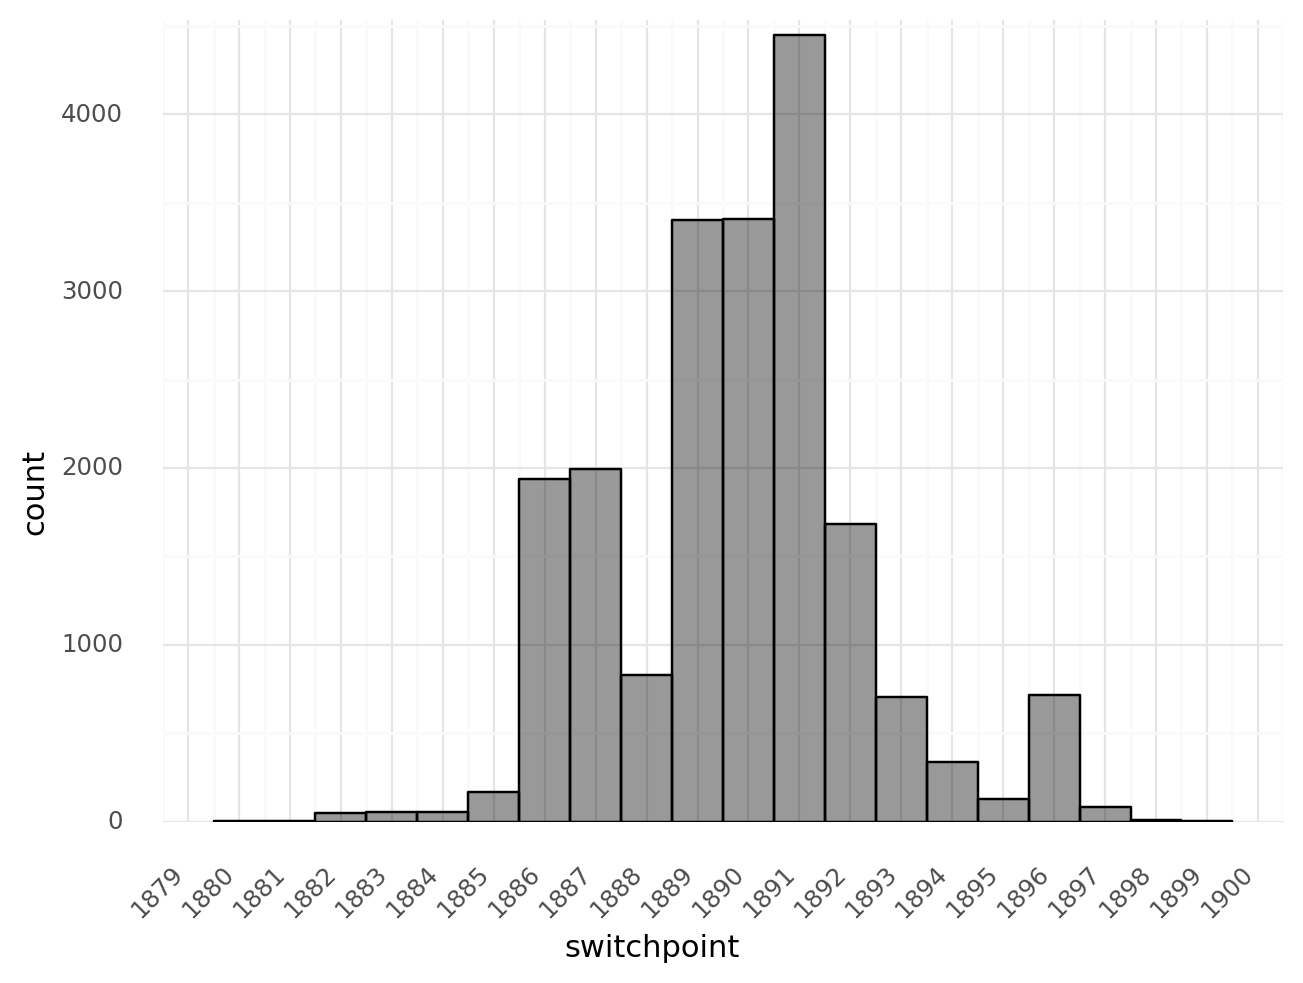

<ggplot: (355977265)>

In [50]:
switchpoint_post = pd.DataFrame({"switchpoint": trace["switchpoint"]})
(
    gg.ggplot(switchpoint_post, gg.aes(x="switchpoint"))
    + gg.geom_histogram(binwidth=1, alpha=0.4, size=0.5, color="black", fill="black")
    + gg.scale_x_continuous(breaks=disasters_data.year)
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.theme(axis_text_x=gg.element_text(angle=45, ha="right"))
)

Posterior predictions automatically generated for missing data.

/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/plotnine/facets/facet_wrap.py:215: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


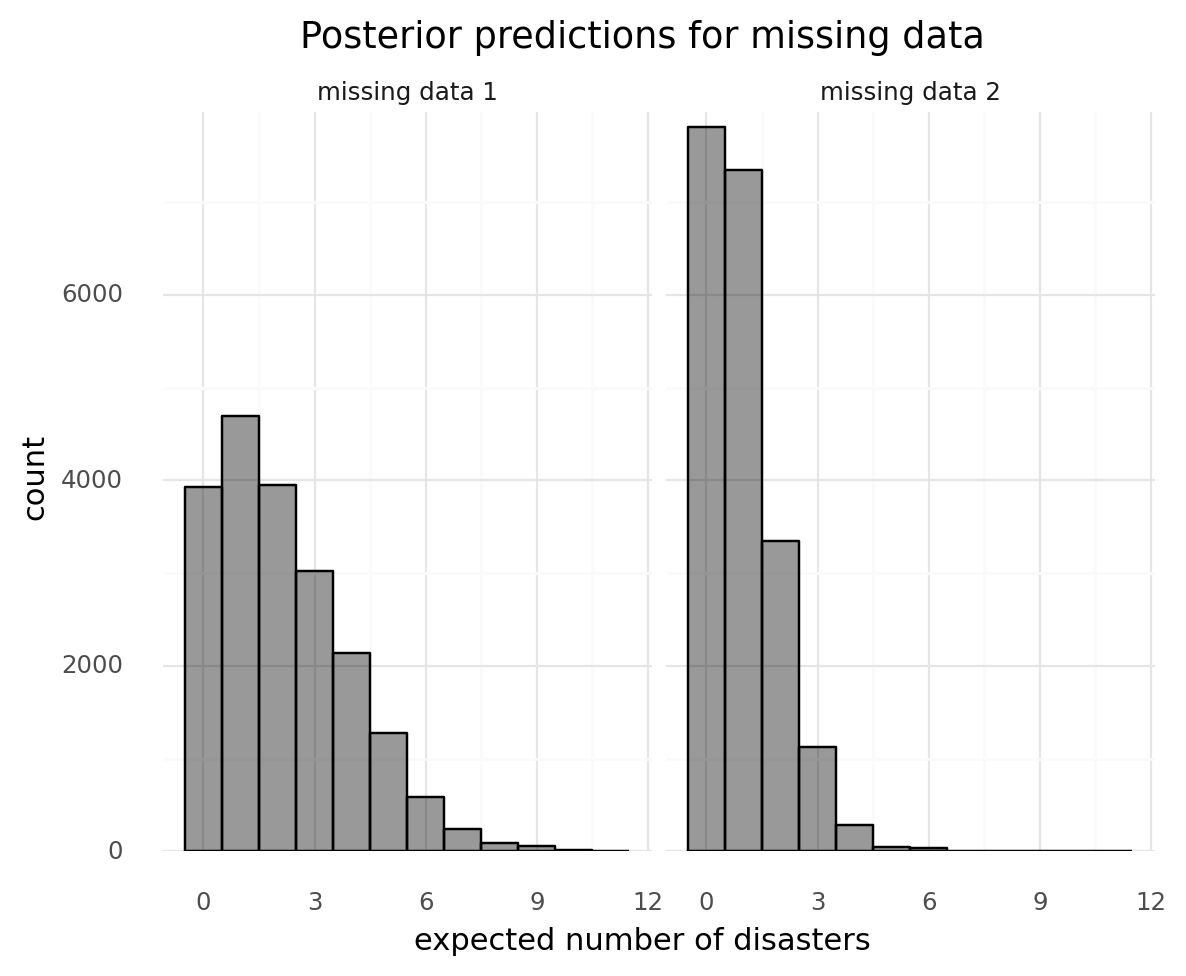

<ggplot: (355902925)>

In [57]:
missing_data_imputation = pd.DataFrame(
    trace["disasters_missing"], columns=["missing data 1", "missing data 2"]
).melt()

(
    gg.ggplot(missing_data_imputation, gg.aes(x="value"))
    + gg.facet_wrap("variable", nrow=1)
    + gg.geom_histogram(binwidth=1, alpha=0.4, size=0.5, color="black", fill="black")
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.labs(
        x="expected number of disasters",
        y="count",
        title="Posterior predictions for missing data",
    )
)

The following plot shows the results of the fit model on top of the original data.
The switchpoint is shown in dark red with its 89% CI in dashed lines and the black dashed line is the accident rate.
The estimates for the imputed data are also shown as green points with 89% CI.

/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 2 rows containing missing values.


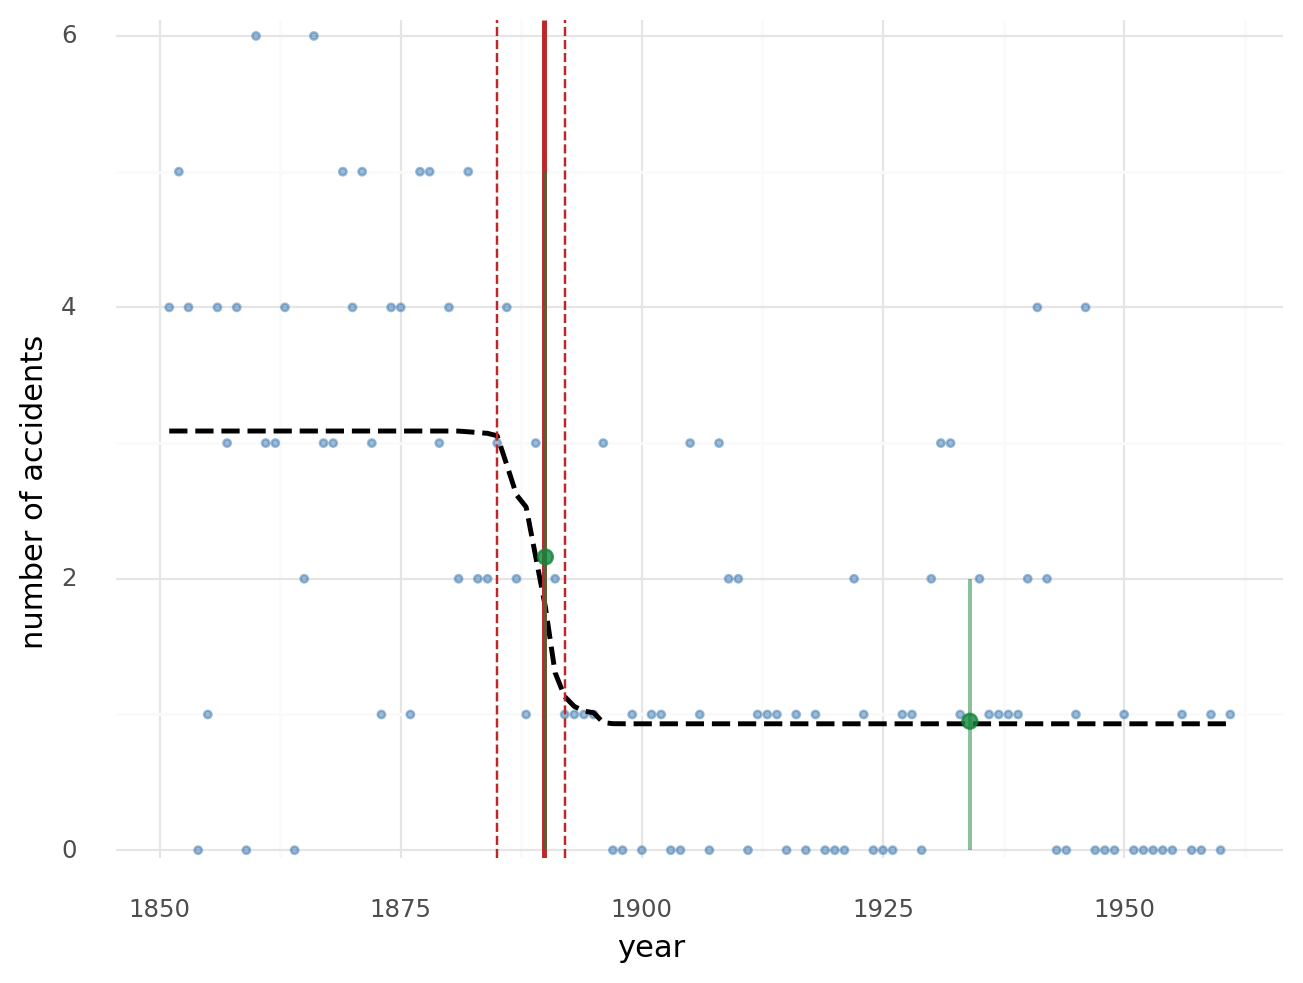

<ggplot: (363565879)>

In [104]:
# Switchpoint summary stats.
switchpoint_mean = trace["switchpoint"].mean()
switchpoint_hdi = az.hdi(trace["switchpoint"], hdi_prob=0.89)

# Accident rate over all years.
average_disasters = np.zeros_like(disasters_data.n_disasters, dtype="float")
for i, year in enumerate(disasters_data.year):
    idx = year < trace["switchpoint"]
    average_disasters[i] = np.mean(
        np.where(idx, trace["early_rate"], trace["late_rate"])
    )

average_disasters_df = pd.DataFrame(
    {"avg_disasters": average_disasters, "year": disasters_data.year}
)

# Imputed data summary.
disaster_impute_summary = az.summary(
    trace, var_names="disasters_missing", hdi_prob=0.89, kind="stats"
)
disaster_impute_summary["year"] = disasters_data[
    disasters_data.n_disasters.isna()
].year.values

# Plotting
switchpoint_color = "#BC272A"
impute_color = "#12853B"
(
    gg.ggplot(disasters_data, gg.aes(x="year"))
    + gg.geom_point(gg.aes(y="n_disasters"), color="#3F7BB1", size=1, alpha=0.5)
    + gg.geom_line(
        gg.aes(y="avg_disasters"), data=average_disasters_df, linetype="--", size=1
    )
    + gg.geom_vline(xintercept=switchpoint_hdi, linetype="--", color=switchpoint_color)
    + gg.geom_vline(xintercept=switchpoint_mean, color=switchpoint_color, size=1)
    + gg.geom_linerange(
        gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"),
        data=disaster_impute_summary,
        color=impute_color,
        size=0.8,
        alpha=0.5,
    )
    + gg.geom_point(
        gg.aes(y="mean"),
        data=disaster_impute_summary,
        color=impute_color,
        size=2.5,
        alpha=0.8,
    )
    + gg.scale_y_continuous(expand=(0.01, 0, 0.02, 0))
    + gg.labs(x="year", y="number of accidents")
)

---

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w